# Capstone Project - The Battle of Neighborhoods

## Title:

### Finding similar neighborhood across cities based on Venues across neighborhood

## 1. Introduction: 
### 1.1 Background:
Often people have to relocate to different cities due to Job change, there is always a confusion on which neighborhood to shift to in a particular city. Varieties of question arises, 
* Should I find the neighborhood which is closer to the new workplace? 
* Should I find the neighborhood which is similar to my current neighborhood?
* Should I explore some unique neighborhoods around?
* Does the cost of living matter there? Or Does the crime rate matter compared to my current neighborhood? and so many different questions arises as the person starts exploring the city..

### 1.2 Business Problem:
As we can get the neighborhood data of every city, the venues around the neighborhood, the distance between neighborhood and venues along with rating of venues, crime rates data, this project aims to predict the similar neighborhood based on the current neighborhood and also the nearest to the new desired place of work

### 1.3 Interest:
Almost all the working professional who desire to relocate to the new city for better opportunity to work needs the tool which suggests them the neighborhood based on their interest of living.

As an instance, Person named "Adam" living in "St. James Town, Downtown Toronto, Canada" has earned a Job in "Midtown south, Manhattan, New York". The proposed model will suggest the neighborhood of Manhattan which is similar to Adam's current neighborhood and also the nearest to his new workplace.

## 2. Data Aquisition and Cleaning

### 2.1 City Data:
#### 2.1.1 __Canada__: 
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M_
Following attribute is fetched from canada data:
* postal code
* Neighborhood
* Borough

Latitude and Longitude of the location can be fetched from the postal code.

For this project, "St. James Town, Downtown Toronto, Canada" is considered as the source city the user is relocating from.

You can check the sample of data below

In [646]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

#### Get the table data from Wiki

In [647]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content, 'html.parser')
table = soup.find_all('table', class_ = 'wikitable') 

#### Cleanup the table data and store it into the DataFrame

In [648]:
toronto_data = pd.read_html(str(table))[0] # Store results onto DataFrame

toronto_data.columns = toronto_data.columns.str.replace(r'\\n', '', regex=True) # Cleanup \n from the column headers

toronto_data = toronto_data.replace(r'\\n','', regex=True) # Cleanup \n from the all rows

toronto_data = toronto_data.replace(r'/',',', regex=True) # Cleanup / from the all rows

indexNames = toronto_data[ toronto_data['Borough'] == 'Not assigned' ].index

toronto_data.drop(indexNames, inplace=True)

toronto_data = toronto_data.reset_index(drop = True)

#### Find out the Latitude and Longitude of each Neighborhood in Toronto

In [649]:
lat_lng_csv = pd.read_csv('https://cocl.us/Geospatial_data')

lat_lng_csv.rename(columns = {'Postal Code': 'Postal code'}, inplace = True)

toronto_data = pd.merge(toronto_data, lat_lng_csv[['Postal code', 'Latitude', 'Longitude']], on = 'Postal code')

toronto_data.drop(columns = ['Postal code'], inplace=True)

toronto_data = toronto_data.loc[toronto_data['Borough'].str.contains('Downtown Toronto')].reset_index(drop = True)

#### Filter "St. James Town, Downtown Toronto, Canada" from data set as it is the source Neighborhood

In [650]:
users_current_data = toronto_data[toronto_data['Neighborhood'] == 'St. James Town']

#
# User's current Neighborhood
#
users_current_data.head()

,Borough,Neighborhood,Latitude,Longitude
3,Downtown Toronto,St. James Town,43.651494,-79.375418


#### 2.1.2 __New York__: 

https://cocl.us/new_york_dataset/newyork_data.json (Curated list of NewYork Neighborhoods)

Manhattan, Newyork is considered as our destination city for this project.

Below you can check the sample of data,

In [651]:
import json
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

#
# Manhattan, NewYork data after cleaning
#
print(manhattan_data.head())

print('\n Manhattan has {} neighborhoods'.format(manhattan_data.shape[0]))

/bin/sh: wget: command not found
     Borough        Neighborhood   Latitude  Longitude
0  Manhattan         Marble Hill  40.876551 -73.910660
1  Manhattan           Chinatown  40.715618 -73.994279
2  Manhattan  Washington Heights  40.851903 -73.936900
3  Manhattan              Inwood  40.867684 -73.921210
4  Manhattan    Hamilton Heights  40.823604 -73.949688

 Manhattan has 40 neighborhoods


### 2.2 Foursquare API:
Foursquare API gives us the following data:
* list of Venues across Neighborhood
* Venue ratings
* Venue Check-ins

We propose a method to solve the problem by finding similar venues across the source and destination neighborhoods. Checking against the time of Check-ins & the location entropy across the nearby similar venues and also considering the geographical space/distance from the desired location of work, we can suggest the set of Neighborhood the user can relocate to.

You can check out the output of FourSquare API where it gives out the number of venues in each neighborhood and number of unique categories in the data set.

#### Define FourSquare credentials and version

In [652]:
CLIENT_ID = 'HMRCWPCJVQTWTZMZIEFGD3D4YD0CKZAHIDYSW3BJ55KKWROO' # your Foursquare ID
CLIENT_SECRET = 'LJP5G15ZQKJDFAEU0UGBLA40X43NDDK0O2KEAI44BYYOSW2W' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

#### Define a function to get the venues near the neighborhood

In [653]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    print("Below are the Venue information for the respective Neighborhoods:")
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        print('{} : {} Venues'.format(name, len(results)))

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [654]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Below are the Venue information for the respective Neighborhoods:
Marble Hill : 25 Venues
Chinatown : 100 Venues
Washington Heights : 90 Venues
Inwood : 57 Venues
Hamilton Heights : 59 Venues
Manhattanville : 46 Venues
Central Harlem : 42 Venues
East Harlem : 42 Venues
Upper East Side : 90 Venues
Yorkville : 100 Venues
Lenox Hill : 100 Venues
Roosevelt Island : 25 Venues
Upper West Side : 68 Venues
Lincoln Square : 95 Venues
Clinton : 100 Venues
Midtown : 100 Venues
Murray Hill : 87 Venues
Chelsea : 100 Venues
Greenwich Village : 100 Venues
East Village : 100 Venues
Lower East Side : 47 Venues
Tribeca : 74 Venues
Little Italy : 100 Venues
Soho : 74 Venues
West Village : 100 Venues
Manhattan Valley : 40 Venues
Morningside Heights : 39 Venues
Gramercy : 72 Venues
Battery Park City : 60 Venues
Financial District : 100 Venues
Carnegie Hill : 86 Venues
Noho : 100 Venues
Civic Center : 87 Venues
Midtown South : 87 Venues
Sutton Place : 93 Venues
Turtle Bay : 100 Venues
Tudor City : 73 Venues

In [655]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))
print('\n')
print(manhattan_venues['Venue Category'].drop_duplicates().reset_index(drop=True))

There are 321 uniques categories.


0         Pizza Place
1         Yoga Studio
2               Diner
3          Donut Shop
4         Coffee Shop
            ...      
316    Baseball Field
317       Sports Club
318      Tech Startup
319      Camera Store
320           Stables
Name: Venue Category, Length: 321, dtype: object


## 3. Exploratory Data Analysis

### 3.1 Venues across source Neighborhood

As we have selected source neighborhood as *St.James Town, Downtown Toronto, Canada*, we fetch the venues around the neighborhood and we can visualize it in the map using folium library as seen below,

In [656]:
toronto_venues = getNearbyVenues(names=users_current_data['Neighborhood'],
                                   latitudes=users_current_data['Latitude'],
                                   longitudes=users_current_data['Longitude']
                                  )

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

Below are the Venue information for the respective Neighborhoods:
St. James Town : 80 Venues
There are 54 uniques categories.


#### 3.1.1 Analysing which venues are around the user's current Neighborhood

In [1066]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from folium import plugins

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto'

latitude = users_current_data.iloc[0]['Latitude']   # Get user's current neighborhood Latitude
longitude = users_current_data.iloc[0]['Longitude'] # Get user's current neighborhood Longitude

#
# Create the colors array for all the unique categories
#
kclusters = len(toronto_venues['Venue Category'].unique()) 
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=16) # create map of Toronto using latitude and longitude values

unique_categories = toronto_venues['Venue Category'].unique().tolist()

#
# Add category markers to map
#
for lat, lng, venue_name, category in zip(toronto_venues['Venue Latitude'], toronto_venues['Venue Longitude'], toronto_venues['Venue'], toronto_venues['Venue Category']):
    label = 'Venue'
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[unique_categories.index(category)],
        fill_opacity=1,
        parse_html=False).add_to(map_toronto)  

#
# Add border for the Neighborhod
#
folium.CircleMarker(
        [latitude, longitude],
        radius=300,
        popup='Neighborhood Center',
        color='red',
        fill=True,
        fill_color='#ff0000',
        fill_opacity=0.05,
        parse_html=False).add_to(map_toronto)
map_toronto

#### 3.1.2 Visualize Venue Categories around user's current Neighborhood

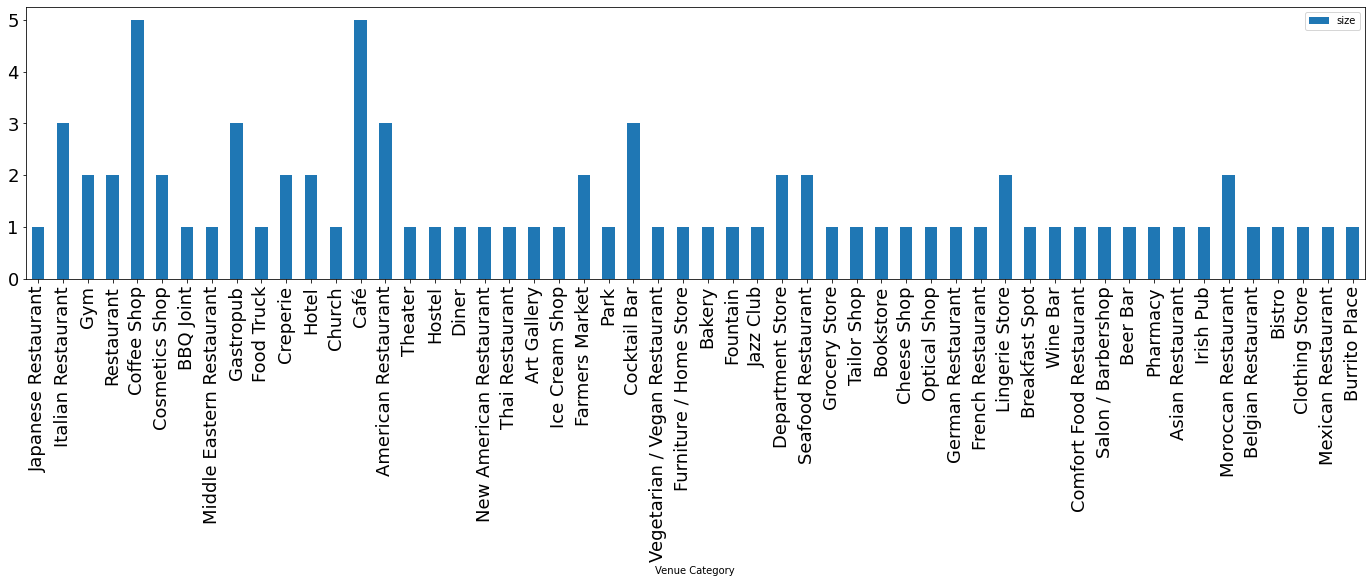

In [879]:
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
%matplotlib inline

toronto_venue_count = toronto_venues[['Venue Category']]
toronto_venue_count['size'] = toronto_venues[['Venue', 'Venue Category']].groupby(['Venue Category']).transform(np.size)
toronto_venue_count = toronto_venue_count.drop_duplicates(subset="Venue Category").set_index(['Venue Category'], drop=True)
#print(toronto_venue_count)
#toronto_venue_count.plot.bar(rot=0)
toronto_venue_count.plot(kind='bar', figsize=(24,5), fontsize='18')

#### 3.1.2 Lets visualize the 20 most common Venues among the above venues

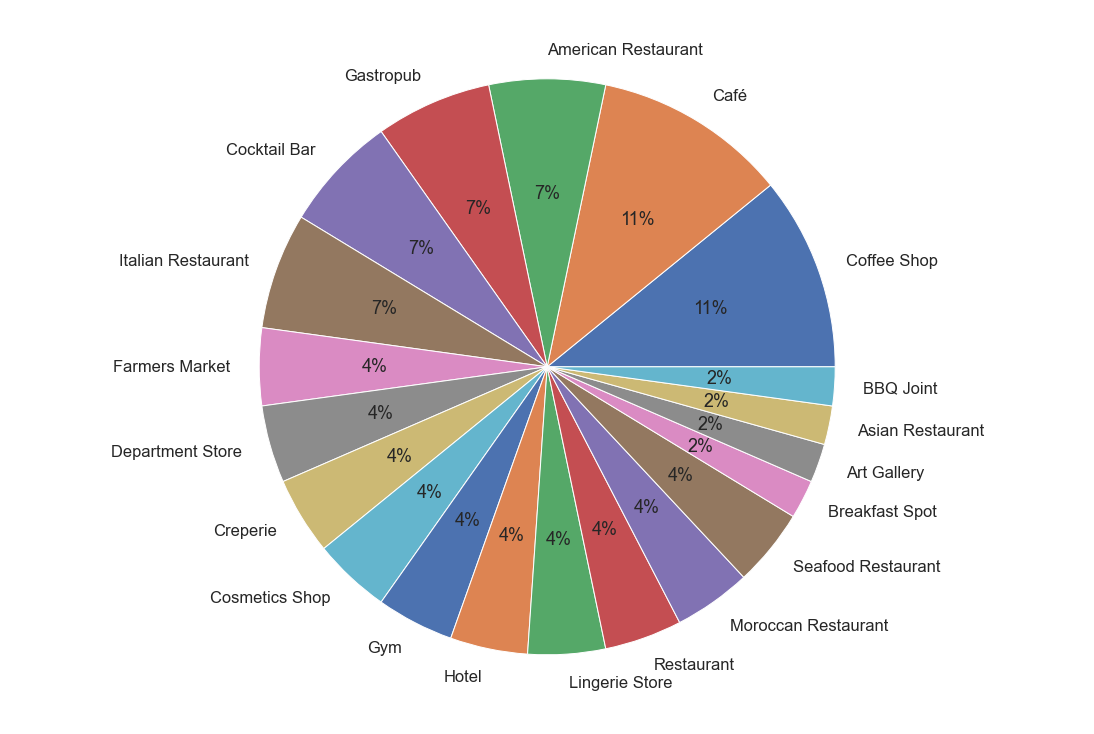

In [1068]:
#
# Declare function to get the nth most common venue
#
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues].tolist()

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 20
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
toronto_venues_sorted.iloc[0, 1:] = return_most_common_venues(toronto_grouped.iloc[0, :], num_top_venues)

#
# Create a DataFrame for Pie Chart
#
value_entries = pd.DataFrame(toronto_grouped.iloc[0][1:]).sort_values(by=[0],ascending=False).reset_index().rename(columns={0: 'Value', 'index': 'Venues'})
toronto_common_venues = return_most_common_venues(toronto_grouped.iloc[0, :], 20)
toronto_common_venues = pd.DataFrame(toronto_common_venues, columns=["Venues"])
toronto_common_venues.index += 1
toronto_common_venues = pd.merge(toronto_common_venues, value_entries, on='Venues')
toronto_common_venues['Value'] = toronto_common_venues['Value'] / toronto_common_venues['Value'].sum()

# Plot the Pie Chart
fig = plt.figure()
ax = fig.add_axes([0,0,2.5,2.5])
ax.axis('equal')
ax.pie(toronto_common_venues['Value'], labels = toronto_common_venues['Venues'], autopct='%1.0f%%')
plt.show()

### 3.2 Venues across destination Borough

#### 3.2.1 Now lets analyse the Neighborhood around Manhattan Borough (Our destination place)

In [1070]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
geolocator = Nominatim(user_agent="ny_explorer")

#
# Get the Destination Borough Latitude and Longitude
#
manhattan_address = 'Manhattan, NY'
manhattan_location = geolocator.geocode(manhattan_address)
manhattan_latitude = manhattan_location.latitude
manhattan_longitude = manhattan_location.longitude

manhattan_map = folium.Map(location=[manhattan_latitude, manhattan_longitude], zoom_start=12)
#
# add Neighborhoods of Manhattan to the map
#
for lat, lon, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(' Neighborhood: ' + str(neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(manhattan_map)

#
# Get the user's New work location and plot it on the map
#
new_work_address = 'Midtown south, Manhattan, New York'
new_work_location = geolocator.geocode(new_work_address)
new_work_latitude = new_work_location.latitude
new_work_longitude = new_work_location.longitude
label = folium.Popup('New Work Location', parse_html=True)
folium.Marker(
    [new_work_latitude, new_work_longitude],
    popup=label,
    icon=folium.Icon(icon='institution', prefix='fa', color='red')).add_to(manhattan_map)

# Plot the map
manhattan_map

#### 3.2.2 Lets visualize 20 common Venues for all the Neighborhood around Manhattan

In [1071]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()

mvalue_entries = pd.DataFrame(manhattan_grouped.iloc[0][1:]).sort_values(by=[0],ascending=False).reset_index().rename(columns={0: 'Value', 'index': 'Venues'})
manhattan_common_venues = return_most_common_venues(manhattan_grouped.iloc[0, :], 400)
manhattan_common_venues = pd.DataFrame(manhattan_common_venues, columns=["Venues"])
manhattan_common_venues.index += 1
manhattan_common_venues = pd.merge(manhattan_common_venues, mvalue_entries, on='Venues')

manhattan_venue_count = manhattan_venues[['Venue Category']]
manhattan_venue_count['Neighborhood'] = manhattan_venues['Neighborhood']
manhattan_venue_count['size'] = manhattan_venues[['Neighborhood','Venue', 'Venue Category']].groupby(['Neighborhood', 'Venue Category']).transform(np.size)
manhattan_venue_count = manhattan_venue_count.fillna(0)
source_list = toronto_venue_count.reset_index()['Venue Category'].to_list()
for index, value in manhattan_venue_count.iterrows():
    if (not value['Venue Category'] in source_list):
        manhattan_venue_count.drop(index, inplace=True)

num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
manhattan_venues_sorted = pd.DataFrame(columns=columns)
manhattan_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    manhattan_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

manhattan_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Battery Park City,Park,Hotel,Gym,Memorial Site,Burger Joint,Wine Shop,Department Store,Italian Restaurant,Plaza,...,Gourmet Shop,Food Court,Shopping Mall,Coffee Shop,Building,Lingerie Store,Electronics Store,Chinese Restaurant,Sandwich Place,Bistro
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Bakery,Italian Restaurant,Wine Shop,Japanese Restaurant,Gym / Fitness Center,Gym,...,Bookstore,Grocery Store,French Restaurant,Shipping Store,Spa,Bar,Pub,Hot Dog Joint,Art Museum,Gourmet Shop
2,Central Harlem,Gym / Fitness Center,American Restaurant,Seafood Restaurant,French Restaurant,Chinese Restaurant,African Restaurant,Bar,Southern / Soul Food Restaurant,Bookstore,...,Ethiopian Restaurant,Gym,Tapas Restaurant,Market,Event Space,Boutique,Spa,Cafeteria,Caribbean Restaurant,Library
3,Chelsea,Art Gallery,Coffee Shop,Italian Restaurant,Seafood Restaurant,American Restaurant,Ice Cream Shop,Boutique,Pizza Place,Market,...,Bakery,Cupcake Shop,Cycle Studio,Bookstore,Park,Cheese Shop,Butcher,Club House,Nightclub,Clothing Store
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Salon / Barbershop,American Restaurant,Optical Shop,Spa,Coffee Shop,Bubble Tea Shop,...,Jewelry Store,Shanghai Restaurant,Greek Restaurant,Mexican Restaurant,Boutique,Dumpling Restaurant,Dessert Shop,Noodle House,Ice Cream Shop,Hotel
5,Civic Center,Coffee Shop,Hotel,French Restaurant,Yoga Studio,Park,Café,Gym / Fitness Center,Cocktail Bar,Spa,...,American Restaurant,Gym,Sushi Restaurant,Wine Shop,Sporting Goods Shop,Men's Store,Building,Boxing Gym,Boutique,Burger Joint
6,Clinton,Theater,Gym / Fitness Center,Coffee Shop,Gym,Spa,Hotel,Thai Restaurant,Sandwich Place,Italian Restaurant,...,Cocktail Bar,Wine Shop,Fried Chicken Joint,Mediterranean Restaurant,Indie Theater,Lounge,Pizza Place,Caucasian Restaurant,Roof Deck,Chinese Restaurant
7,East Harlem,Mexican Restaurant,Bakery,Latin American Restaurant,Thai Restaurant,Pizza Place,Deli / Bodega,Spa,Gas Station,Taco Place,...,Steakhouse,French Restaurant,Spanish Restaurant,Café,Seafood Restaurant,Chinese Restaurant,Sandwich Place,Cocktail Bar,Park,Restaurant
8,East Village,Pizza Place,Cocktail Bar,Bar,Coffee Shop,Wine Bar,Japanese Restaurant,Speakeasy,Ice Cream Shop,Mexican Restaurant,...,Italian Restaurant,Grocery Store,Gourmet Shop,Café,Ramen Restaurant,Bagel Shop,Seafood Restaurant,Greek Restaurant,Salon / Barbershop,Vietnamese Restaurant
9,Financial District,Coffee Shop,Hotel,Pizza Place,Café,Italian Restaurant,Cocktail Bar,American Restaurant,Salad Place,Falafel Restaurant,...,Food Truck,Sandwich Place,Juice Bar,Steakhouse,Monument / Landmark,Mediterranean Restaurant,Gourmet Shop,Memorial Site,Park,Japanese Restaurant


## 4. Predictive Modelling

### 4.1 Partition Based Clustering

#### 4.1.1 Finding the best k value for clustering

(41, 325)

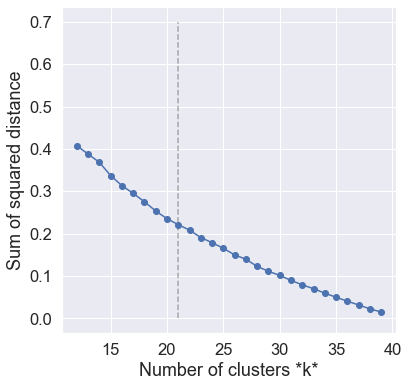

In [1072]:
from sklearn.cluster import KMeans
# Combining Source and Destination to find the clusters
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
combined_grouped_clustering = toronto_grouped_clustering.append(manhattan_grouped_clustering)
combined_grouped_clustering = combined_grouped_clustering.fillna(0).reset_index(drop=True)

# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(12, 40))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(combined_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.vlines(x=21, ymin=0, ymax=0.7, linestyle='--', colors='#0000004a')
combined_grouped_clustering.shape

#### 4.1.2 Clusters of Neighborhoods

In [1077]:
# set number of clusters
kclusters = 21

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(combined_grouped_clustering)

# check cluster labels generated for each row in the dataframe
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_;

# add clustering labels
combined_data = users_current_data.append(manhattan_data)

combined_venues_sorted = toronto_venues_sorted.append(manhattan_venues_sorted)

combined_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
combined_data = combined_data.join(combined_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

combined_data.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
3,Downtown Toronto,St. James Town,43.651494,-79.375418,6,Coffee Shop,Café,American Restaurant,Gastropub,Cocktail Bar,...,Gym,Hotel,Lingerie Store,Restaurant,Moroccan Restaurant,Seafood Restaurant,Breakfast Spot,Art Gallery,Asian Restaurant,BBQ Joint
0,Manhattan,Marble Hill,40.876551,-73.910660,5,Sandwich Place,Gym,Coffee Shop,Yoga Studio,Steakhouse,...,Miscellaneous Shop,Diner,Pharmacy,Discount Store,Kids Store,Department Store,Ice Cream Shop,American Restaurant,Deli / Bodega,Pizza Place
1,Manhattan,Chinatown,40.715618,-73.994279,12,Chinese Restaurant,Bakery,Cocktail Bar,Salon / Barbershop,American Restaurant,...,Jewelry Store,Shanghai Restaurant,Greek Restaurant,Mexican Restaurant,Boutique,Dumpling Restaurant,Dessert Shop,Noodle House,Ice Cream Shop,Hotel
2,Manhattan,Washington Heights,40.851903,-73.936900,10,Café,Bakery,Grocery Store,Mobile Phone Shop,Chinese Restaurant,...,Supplement Shop,Pizza Place,Sandwich Place,Gym,Deli / Bodega,New American Restaurant,Spa,Wine Shop,Latin American Restaurant,Donut Shop
3,Manhattan,Inwood,40.867684,-73.921210,10,Mexican Restaurant,Café,Pizza Place,Bakery,Lounge,...,American Restaurant,Park,Moving Target,Spanish Restaurant,Bus Station,Caribbean Restaurant,Supermarket,Fast Food Restaurant,Empanada Restaurant,Farmers Market


#### 4.1.3 Visualize the predicted clusters

In [1169]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters matching the source Neighborhood
x = np.arange(kclusters)
rainbow = ['red' for i in x]
colors = []
rainbow[combined_data.loc[combined_data['Neighborhood'] == 'St. James Town']['Cluster Labels'].iloc[0]] = 'darkgreen'

# add Source cluster marker to the map
markers_colors = []
source_cluster = combined_data.loc[combined_data['Neighborhood'] == 'St. James Town']['Cluster Labels'].iloc[0]
#for lat, lon, poi, cluster in zip(combined_data['Latitude'], combined_data['Longitude'], combined_data['Neighborhood'], combined_data['Cluster Labels']):
label = folium.Popup('St. James Town: Cluster ' + str(source_cluster), parse_html=True)
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup=label,
    color=rainbow[int(source_cluster)],
    fill=True,
    fill_color=rainbow[int(source_cluster)],
    fill_opacity=0.7).add_to(map_clusters)
map_clusters

In [1296]:
#
# Add Destination clusters to the map
# Red markers  - Similar Neighborhood
# Gray markers - Non-Similar Neighborhood
#
manhattan_map = folium.Map(location=[manhattan_latitude, manhattan_longitude], zoom_start=12)

# add markers to the map
no_of_matches = int(combined_data.loc[combined_data['Cluster Labels'] == source_cluster].shape[0]) - 1
distance = []; #[[latitude, longitude] for i in range(0,no_of_matches)]
distance.append([new_work_latitude, new_work_longitude])
for lat, lon, poi, cluster in zip(combined_data['Latitude'], combined_data['Longitude'], combined_data['Neighborhood'], combined_data['Cluster Labels']):
    radius = 4
    if (source_cluster == cluster and not poi == 'St. James Town'):
        distance.append([lat, lon])
        radius = 7
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=radius,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(manhattan_map)

label="New Work Location"
folium.Marker(
    [new_work_latitude, new_work_longitude],
    popup=label,
    icon=folium.Icon(icon='institution', prefix='fa', color='orange')).add_to(manhattan_map)
print(distance) 
folium.PolyLine([distance[0], distance[1]], color="darkgreen", weight=3.5, opacity=0.5, tooltip="Distance: ").add_to(manhattan_map)
folium.PolyLine([distance[0], distance[2]], color="darkgreen", weight=3.5, opacity=0.5).add_to(manhattan_map)
folium.PolyLine([distance[0], distance[3]], color="darkgreen", weight=3.5, opacity=0.5).add_to(manhattan_map)
folium.PolyLine([distance[0], distance[4]], color="darkgreen", weight=3.5, opacity=10.5).add_to(manhattan_map)

manhattan_map

[[40.7498417, -73.984251], [40.721521967443216, -74.01068328559087], [40.73443393572434, -74.00617998126812], [40.75204236950722, -73.96770824581834], [40.746917410740195, -73.97121928722265]]


#### 4.1.4 Visualize the distance from user's new work location to the similar Predicted Neighborhoods

In [1187]:
from math import sin, cos, sqrt, atan2, radians
def find_distance_from_workplace(dest_lat, dest_long):
    # approximate radius of earth in km
    R = 6373.0
    # Convert latitude to radians
    lat1 = radians(new_work_latitude)
    lon1 = radians(new_work_longitude)
    lat2 = radians(dest_lat)
    lon2 = radians(dest_long)
    # find distance from lat and lon
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    # Calculating distance using HAVERSINE FORMULA
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    print("Distance from new work place: ", str(round(distance, 2)), " km")

#### 4.1.5 Visualize the Top 20 common Venues across Neighborhood

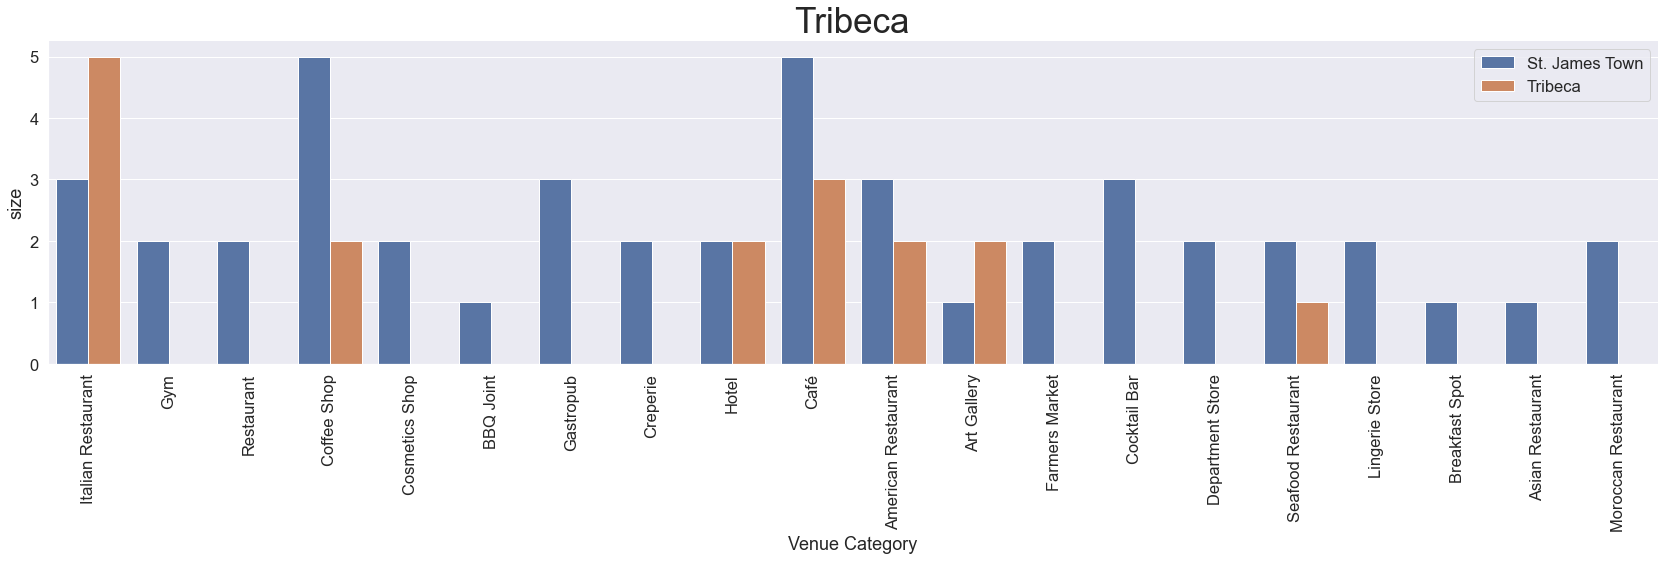

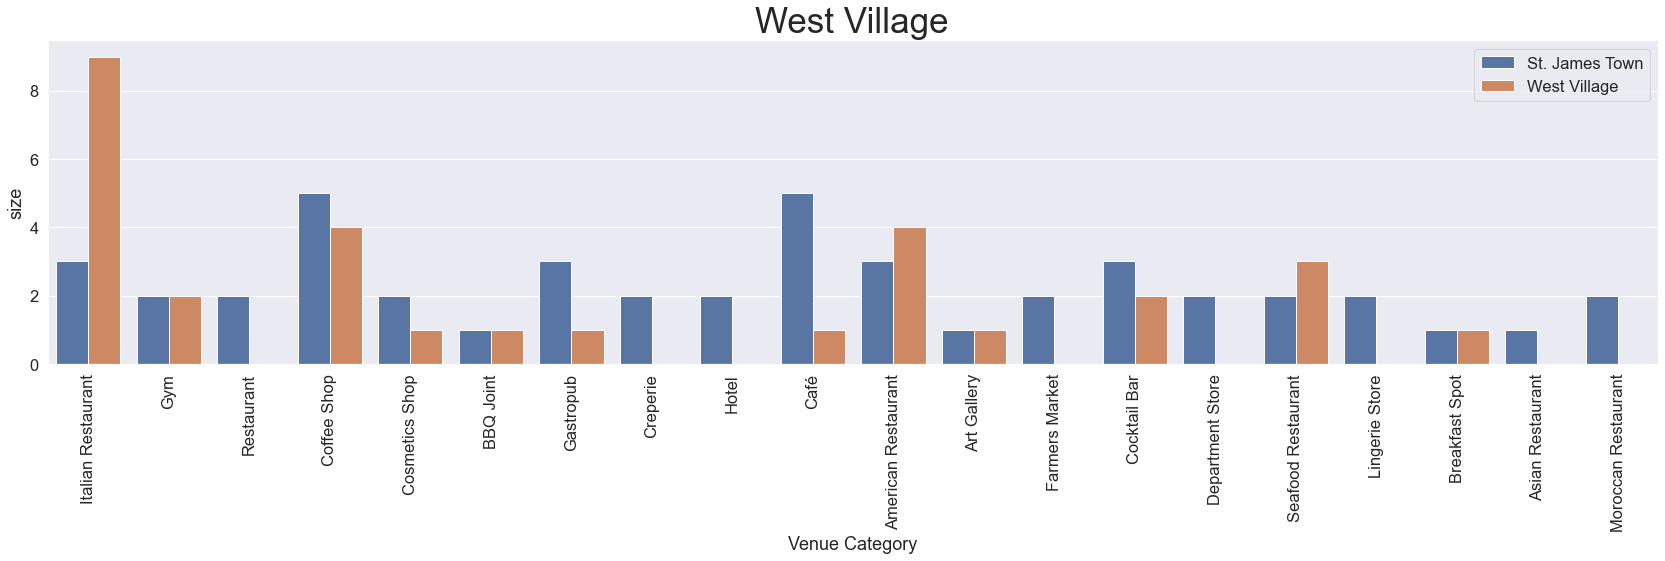

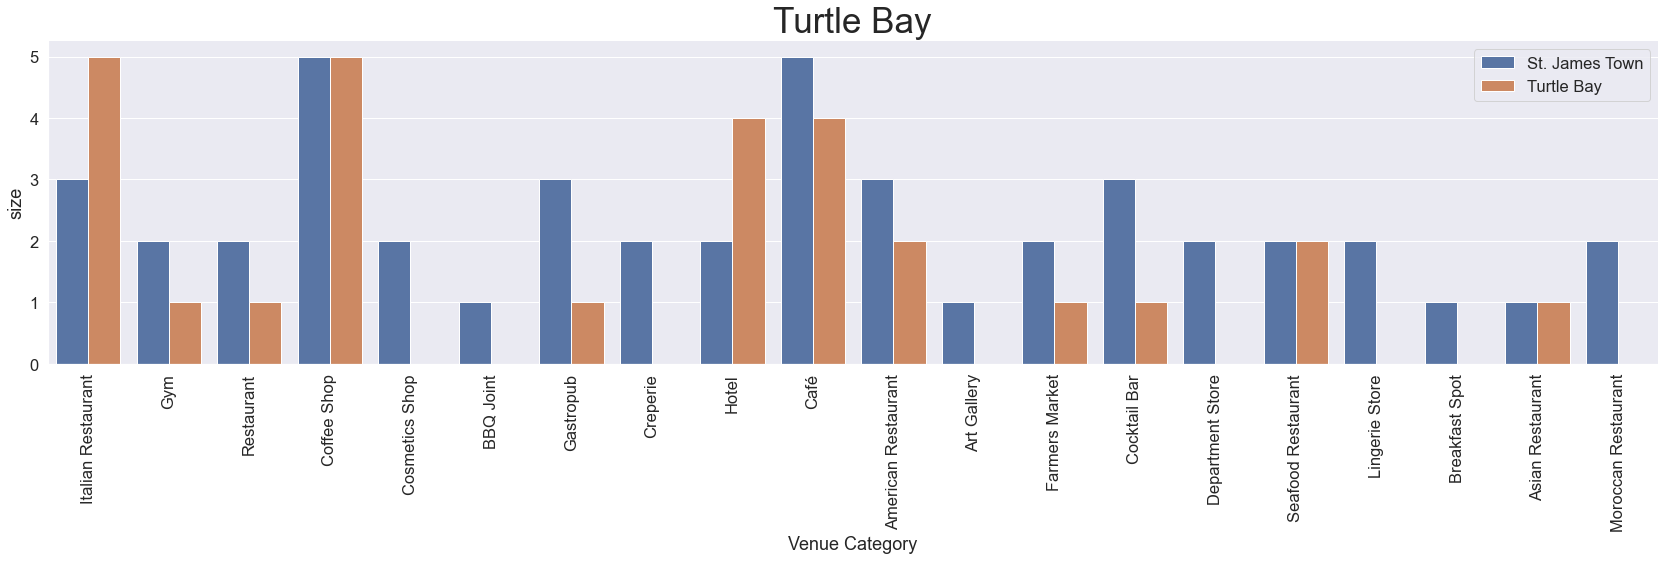

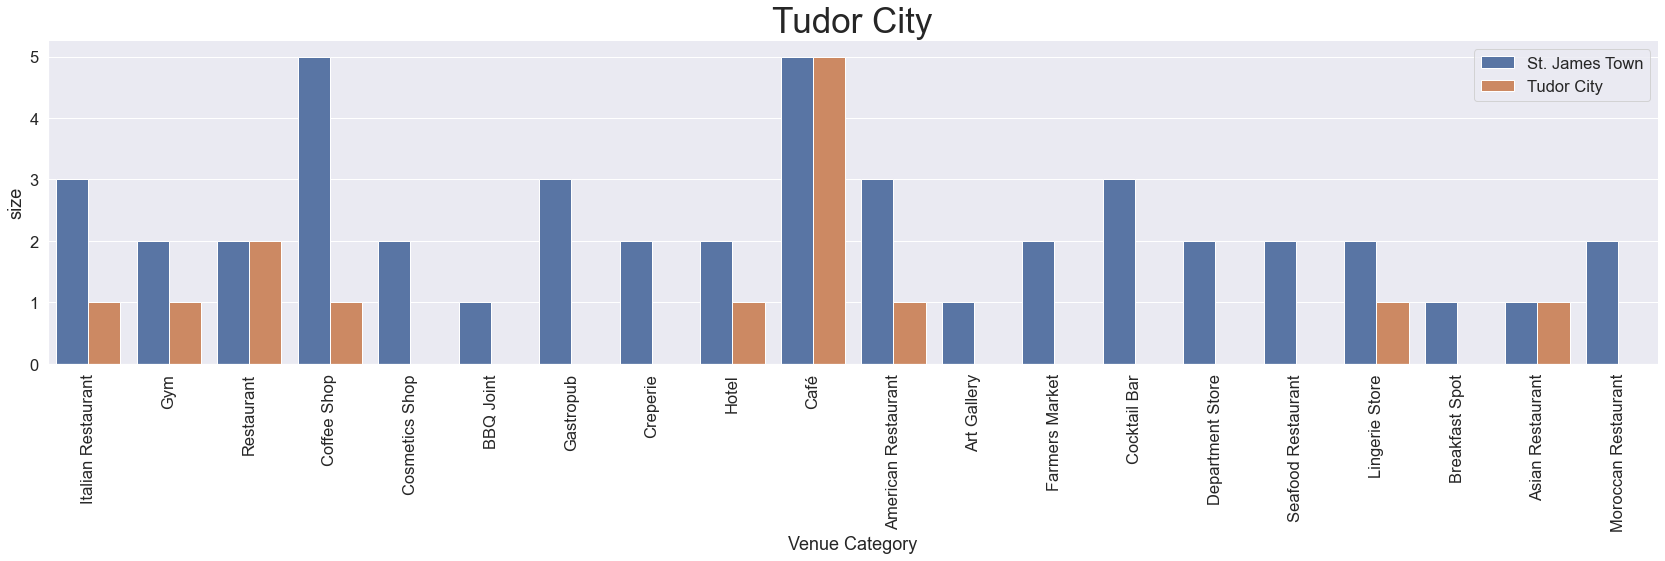

In [1298]:
source_venue = toronto_venue_count
#print(source_venue)

for lat, lon, neighborhood, cluster in zip(combined_data['Latitude'], combined_data['Longitude'], combined_data['Neighborhood'], combined_data['Cluster Labels']):
    if (not neighborhood == 'St. James Town' and cluster == source_cluster):
        dest_venues = manhattan_venue_count.loc[manhattan_venue_count['Neighborhood'] == neighborhood].drop_duplicates().set_index('Venue Category')
        dest_venues_top_20 = source_venue.append(dest_venues[dest_venues.index.isin(source_venue.index)]).reset_index() 
        sns.set(font_scale=1.5)
        g = sns.factorplot(x='Venue Category', y='size', hue='Neighborhood', kind='bar', data=dest_venues_top_20, size=6, aspect=4, legend=False)
        plt.legend(loc='upper right')
        g.set_xticklabels(rotation=90)
        plt.subplots_adjust(top=0.9)
        g.fig.suptitle(neighborhood, fontsize=35)


#### 4.1.4 Examining Clusters

## 5.1 Conclusion

As we saw in the visualizations above, Compared to user's current neighborhood, Turle Bay and West Village is the suggested Neighborhoods based on the top common venue preferences.

__Tutle Bay Neighborhood__ has 12 top common similar venues which includes different genres of restaurants like Italian, American, Seafood and Asian. And even has a Gastro pub and a Cocktail bar if the user prefers to put on some Alchohol. The Neighborhood has a Gym for some quality time with fitness. Also has a Farmer's Market if the user prefers picking up the veggies to cook some nutritous food. And there is no shortages of Coffee shops and Cafe to spend quality time with friends or just have a productive time with themselves.

This Neighborhood is 2.52 KM far from the user's new work place, cycling is both effective towards health and time.

__West Village Neighborhood__ also has 12 top common similar venues. Even this neighborhood has many restaurants -- 9 Italian, 4 American, 3 Seafood Restaurants, BBQ Joint and a breakfast spot. For alchohol lovers, there is 1 Gastro pub and 2 Cocktail bars. There are 2 Gyms in the Neighborhood, so get ready to get fit. There are coffeshops and cafe available to be productive or just for fun. Also there is a cosmetic shop in the block, if you prefer to have some makeover. 

This Neighborhood is 1.15 KM far from the user's new work place, which is a short walk.
